In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from matplotlib import style

plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['red'])

In [2]:
df = pd.read_csv('./BankChurners.csv')
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Existing Customer', 1, inplace=True)
df['Attrition_Flag'].mask(df['Attrition_Flag'] == 'Attrited Customer', 0, inplace=True)
df['Attrition_Flag'] = df['Attrition_Flag'].astype(int)
print(df.isna().sum())

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


In [3]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag                int32
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [4]:
#defining and splitting variables
X = df.drop(columns=['CLIENTNUM', 'Attrition_Flag'])
y = df['Attrition_Flag']

idx_train, idx_test = train_test_split(X.index, stratify=y, random_state=999)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]

In [5]:
#checking proportions of zeros in train and val set (I want to ensure proportions are equal (or almost equal))

count = (y_train == 0).sum()
print('Percent of zeros in y train : ', count/len(y_train))
count = (y_test == 0).sum()
print('Percent of zeros in y val : ', count/len(y_test))

Percent of zeros in y train :  0.16063199473337722
Percent of zeros in y val :  0.16074249605055294


In [6]:
#selecting numerical and categorical columns

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X_train.select_dtypes(include='object').columns


In [7]:
#listing classifiers, scalers and transformers that should be compared

classifiers = [
    DummyClassifier(strategy='stratified'),
    LogisticRegression(max_iter=500), 
    KNeighborsClassifier(2), 
    ExtraTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier(),
    CatBoostClassifier(silent=True),
    LGBMClassifier(verbose=-1)
]

scalers = [StandardScaler(), MinMaxScaler(feature_range=(0,1)), Normalizer()]

categorical_transformers = [OrdinalEncoder(), OneHotEncoder()]

In [8]:
transformer_numerical = Pipeline(steps = [
    ('num_trans', MinMaxScaler(feature_range=(0,1)))
])

transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, numerical_columns),
    ('categorical', transformer_categorical, categorical_columns)
])

In [9]:
pipe = Pipeline(steps = [
            ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier())
            ])
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_trans',
                                                                   MinMaxScaler())]),
                                                  Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_trans',
                                                                   OneHotEncoder())]),
                                                  Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [10]:
#empty dataframe for model evaluation parameters
models_df = pd.DataFrame()

#preparing pipeline
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', None)
])

#ignoring warnings(append will not be supported in the future[used at the end of current cell])
import warnings
warnings.filterwarnings("ignore")

#changing params for each model
for model in classifiers:
    for num_tr in scalers:
        for cat_tr in categorical_transformers:
            pipe_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr,
                'classifier': model
            }
            pipe.set_params(**pipe_params)

            start_time = time.time()
            pipe.fit(X_train, y_train)   
            end_time = time.time()

            score = pipe.score(X_test, y_test)
            y_pred = pipe.predict(X_test)
            try:
                auc = roc_auc_score(y_pred, y_test)
            except:
                auc = None

            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'score': auc,
                        'time_elapsed': end_time - start_time
            }

            models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))


In [11]:
models_df[['model', 'score', 'time_elapsed']] .groupby('model') .aggregate({
        'score': ['mean','std', 'min', 'max'],
        'time_elapsed': ['mean','std', 'min', 'max']
        }).reset_index().sort_values(('score', 'mean'), ascending=False)

model     score                                \
                               mean       std       min       max   
0      CatBoostClassifier  0.954025  0.024764  0.918763  0.970371   
4          LGBMClassifier  0.947369  0.019677  0.921162  0.961182   
8           XGBClassifier  0.946925  0.020042  0.918854  0.960566   
6  RandomForestClassifier  0.929311  0.023017  0.896439  0.951820   
7                     SVC  0.890074  0.014650  0.871861  0.904828   
5      LogisticRegression  0.837247  0.006344  0.828931  0.843592   
2     ExtraTreeClassifier  0.754932  0.037106  0.692541  0.795115   
3    KNeighborsClassifier  0.663063  0.085517  0.584363  0.772604   
1         DummyClassifier  0.499732  0.007279  0.489526  0.511268   

  time_elapsed                                
          mean       std       min       max  
0     6.164781  0.497552  5.590044  6.986628  
4     0.254040  0.034801  0.214072  0.299588  
8     0.698049  0.234840  0.500842  1.039840  
6     1.707189  0.636221  1.246573  2.664465  
7     1.272019  0.519764  0.763474  1.934850  
5     0.131328  0.043599  0.063056  0.182523  
2     0.020939  0.002252  0.018997  0.025001  
3     0.016260  0.001736  0.014008  0.018546  
1     0.018674  0.007136  0.013547  0.029503

In [12]:
models_df.sort_values('score', ascending=False)

,model,num_trans,cat_trans,score,time_elapsed
0,CatBoostClassifier,StandardScaler,OneHotEncoder,0.970371,6.986628
0,CatBoostClassifier,MinMaxScaler,OneHotEncoder,0.970371,5.590044
0,CatBoostClassifier,MinMaxScaler,OrdinalEncoder,0.969523,5.753069
0,CatBoostClassifier,StandardScaler,OrdinalEncoder,0.969523,6.299076
0,LGBMClassifier,MinMaxScaler,OneHotEncoder,0.961182,0.267590
0,LGBMClassifier,StandardScaler,OrdinalEncoder,0.961182,0.214072
0,XGBClassifier,StandardScaler,OrdinalEncoder,0.960566,0.500842
0,XGBClassifier,MinMaxScaler,OrdinalEncoder,0.960566,0.509608
0,LGBMClassifier,MinMaxScaler,OrdinalEncoder,0.960261,0.227085
0,XGBClassifier,StandardScaler,OneHotEncoder,0.959077,0.543137


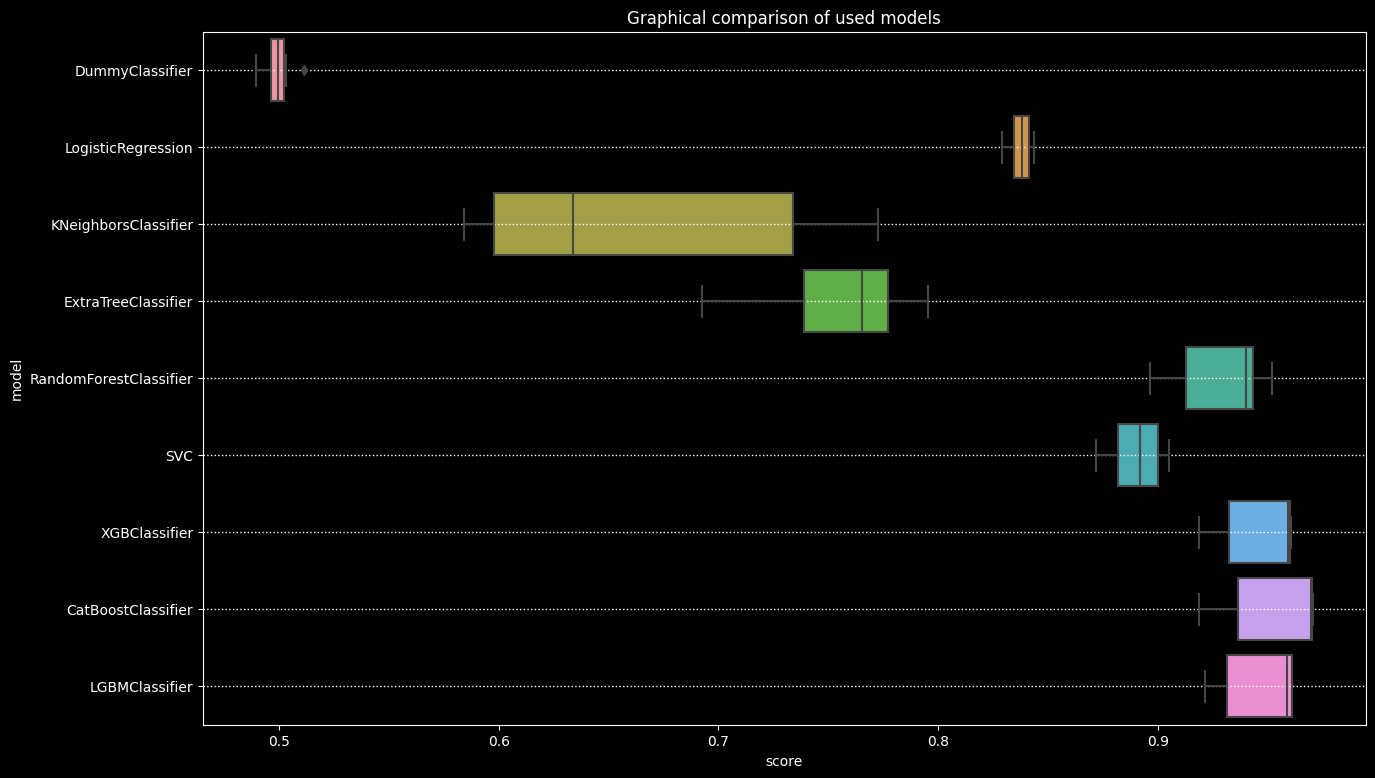

In [13]:
plt.figure(figsize=(15,9))
plt.title('Graphical comparison of used models')
sns.boxplot(data=models_df, x='score', y='model')
plt.grid(axis='y', linestyle='dotted', lw=1)
plt.show()

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

encoder = OneHotEncoder(sparse_output=False, handle_unknown="error", dtype=float).set_output(transform="pandas")

one_hot_encoded_train = encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_test = encoder.transform(X_test[categorical_columns])

X_train.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)


In [15]:
collinear_columns_to_drop = ['Education_Level_Unknown', 'Marital_Status_Unknown', 'Income_Category_Unknown']

X_train.drop(columns=collinear_columns_to_drop, inplace=True)
X_test.drop(columns=collinear_columns_to_drop, inplace=True)

In [16]:
#testing multicollinearity one more time

vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

                           feature       VIF
0                     Customer_Age  2.731767
1                  Dependent_count  1.048357
2                   Months_on_book  2.702885
3         Total_Relationship_Count  1.157591
4           Months_Inactive_12_mon  1.013509
5            Contacts_Count_12_mon  1.039086
6                     Credit_Limit       inf
7              Total_Revolving_Bal       inf
8                  Avg_Open_To_Buy       inf
9             Total_Amt_Chng_Q4_Q1  1.208544
10                 Total_Trans_Amt  3.308705
11                  Total_Trans_Ct  3.105284
12             Total_Ct_Chng_Q4_Q1  1.218025
13           Avg_Utilization_Ratio  3.030361
14                        Gender_F       inf
15                        Gender_M       inf
16         Education_Level_College  1.518135
17       Education_Level_Doctorate  1.253783
18        Education_Level_Graduate  2.123998
19     Education_Level_High School  1.875951
20   Education_Level_Post-Graduate  1.281895
21      Ed

In [17]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=999)
cv_results = cross_validate(CatBoostClassifier(verbose=False), X_train, y_train, scoring='roc_auc', cv=cv, return_train_score=True)

In [18]:
#checking discrepancy between train and validation results

print('Performance on a train set: ', cv_results['train_score']*100, '%')
print('Performance on a validation set: ', cv_results['test_score']*100, '%')
print('Differences: ', (cv_results['train_score']-cv_results['test_score'])*100, 'percentage points')

Performance on a train set:  [99.99134121 99.98439007 99.98704195 99.99001527 99.99421408 99.99222517
 99.98885005 99.98870942 99.9935712  99.99112022 99.98627853 99.98840807
 99.99423417 99.99021617 99.9933703  99.99228544 99.99081887 99.98762456
 99.99105995 99.99351093 99.99246625 99.99190373 99.98752411 99.99298859
 99.9887496 ] %
Performance on a validation set:  [99.44037287 99.71391835 99.42172935 99.07746705 99.3747991  99.00835744
 99.1485053  99.51655416 99.6557377  99.28833173 99.41497911 99.48569592
 99.28222437 99.50498232 99.14721954 99.21504339 99.42687239 99.67566699
 99.2568306  99.27000964 99.45580199 99.235937   99.65445194 99.3924783
 99.2246866 ] %
Differences:  [0.55096834 0.27047171 0.5653126  0.91254822 0.61941498 0.98386773
 0.84034474 0.47215526 0.33783349 0.70278849 0.57129942 0.50271215
 0.7120098  0.48523385 0.84615076 0.77724204 0.56394648 0.31195757
 0.73422935 0.72350129 0.53666426 0.75596673 0.33307216 0.60051029
 0.764063  ] percentage points


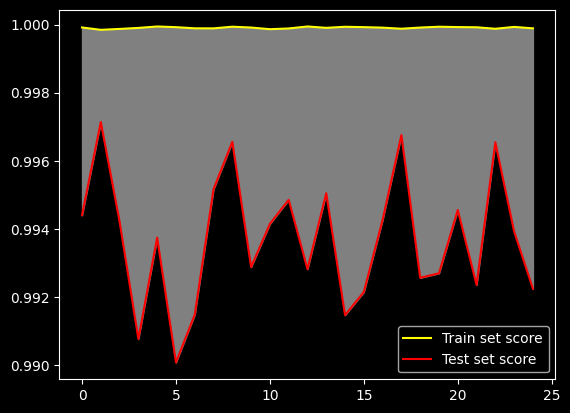

In [36]:
plt.plot(cv_results['train_score'], color='yellow', label='Train set score')
plt.plot(cv_results['test_score'], color='red', label='Test set score')
plt.fill_between(x=np.linspace(0,24,25), y1=cv_results['train_score'], y2=cv_results['test_score'], color='gray')
plt.legend()
plt.show()

In [22]:
y_pred = CatBoostClassifier(verbose=False).fit(X_train, y_train).predict(X_test)
print(f'ROC_AUC score: {roc_auc_score(y_pred, y_test)}')
print(f'F1 score: {f1_score(y_pred, y_test)}')
print(f'Precision: {precision_score(y_pred, y_test)}')
print(f'Recall: {recall_score(y_pred, y_test)}')
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')

ROC_AUC score: 0.9705047935824692
F1 score: 0.9866729015665187
Precision: 0.9929411764705882
Recall: 0.9804832713754646
Accuracy: 0.9774881516587678
